In [1]:
## Plan du Notebook (recherchez #i)
#1 Import
#2 Lecture du fichier de données récupéré par requête sur le site
#3 Transformation des données Title et Body
#4 Transformation des tags
#5 Limitation des tags aux 100 les plus fréquents
#6 Séparation du jeu de données en train / test
#7 Bag of words : CountVectorizer/gensim
#8 Bag of words : tfidfmodel
#9 Sauvegarde des différentes objets pour utilisation dans le notebook de modélisation

In [2]:
#1 Import
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import gensim
import spacy
import string
import re
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import EnglishStemmer
from sklearn.model_selection import train_test_split
import gensim.corpora as corpora
from gensim.models import TfidfModel
from joblib import dump, load
import pickle
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\devra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\devra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\devra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\devra\AppData\Roaming\nltk_data...


In [3]:
#2 Lecture du fichier de données récupéré par requête sur le site
raw_data0 = pd.read_csv('QueryResults.csv')

In [4]:
raw_data0.head(5)

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
0,mqtt async wait for concurrent messages then r...,<p>I have this process for home automation pro...,<javascript><node.js><http><async-await><mqtt>,54553853,1,1286,1,1
1,Where can I find a nice .NET Tab Control for f...,<p>I'm doing this application in C# using the ...,<c#><.net><winforms><tabcontrol><krypton>,712530,11,22118,5,6
2,How to smoothly move a button in cocos2d Xcode,"<p>I have a jump button, that when clicked the...",<iphone><ios><cocoa><opengl-es><cocos2d-iphone>,18655261,4,263,1,2
3,How to get NSImage of generic folder icon on O...,<p>I'm writing a Cocoa application that displa...,<objective-c><cocoa><icons><directory><nsimage>,1441946,13,4639,3,1
4,Replace query string with '/' via .htaccess file,"<p><a href=""http://thewebsitedemo.com/Just-dia...",<php><string><.htaccess><url><replace>,20902469,0,87,1,1


In [5]:
raw_data0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          50000 non-null  object
 1   Body           50000 non-null  object
 2   Tags           50000 non-null  object
 3   Id             50000 non-null  int64 
 4   Score          50000 non-null  int64 
 5   ViewCount      50000 non-null  int64 
 6   FavoriteCount  50000 non-null  int64 
 7   AnswerCount    50000 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 3.1+ MB


In [6]:
#Seules sont prises en compte les données Title, Body et Tags
raw_data = raw_data0[['Title','Body','Tags']].copy()

In [7]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   50000 non-null  object
 1   Body    50000 non-null  object
 2   Tags    50000 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


In [8]:
# % de valeurs manquantes sur tout le dataframe
taux_var_incomplete = raw_data.isnull().sum().sum() / len(raw_data) / len(raw_data.columns) * 100
taux_var_incomplete

0.0

In [9]:
#3 Transformation des données Title et Body

In [10]:
# Fonction de suppression des balises HMTL

def suppr_balises_html(text):
 
    soup = BeautifulSoup(text, "html.parser")
    for data in soup(['style', 'script']):
          data.decompose()
            
    text_out = ' '.join(soup.stripped_strings)        
    return text_out

In [11]:
# Application de la suppression de balises à la donnée Body (donnée Title non concernée)
raw_data['Body_trf'] = raw_data['Body'].apply(suppr_balises_html)

In [12]:
raw_data.head(5)

,Title,Body,Tags,Body_trf
0,mqtt async wait for concurrent messages then r...,<p>I have this process for home automation pro...,<javascript><node.js><http><async-await><mqtt>,I have this process for home automation projec...
1,Where can I find a nice .NET Tab Control for f...,<p>I'm doing this application in C# using the ...,<c#><.net><winforms><tabcontrol><krypton>,I'm doing this application in C# using the fre...
2,How to smoothly move a button in cocos2d Xcode,"<p>I have a jump button, that when clicked the...",<iphone><ios><cocoa><opengl-es><cocos2d-iphone>,"I have a jump button, that when clicked the pl..."
3,How to get NSImage of generic folder icon on O...,<p>I'm writing a Cocoa application that displa...,<objective-c><cocoa><icons><directory><nsimage>,I'm writing a Cocoa application that displays ...
4,Replace query string with '/' via .htaccess file,"<p><a href=""http://thewebsitedemo.com/Just-dia...",<php><string><.htaccess><url><replace>,http://thewebsitedemo.com/Just-dial/Chandigarh...


In [13]:
# Application de cette étape de transformation à un message d'exemple
example_in = "<p>Fictional example, not present in the Dataframe, to explicit The 5 different stages of the NLP transformations : Remove HTML tags; tokenize; remove StopWords (and small words like C#, R, ...); Lemmatize; Stemming. <p>"
print('---------------------------------------------------------------')
print ('Suppression des balises HTML : ')
print('---------------------------------------------------------------')
print ('Exemple avant transformation : ')
print (example_in)
print('---------------------------------------------------------------')
example_out = suppr_balises_html(example_in)
print ('Après transformation : ')
print (example_out)
print('---------------------------------------------------------------')

---------------------------------------------------------------
Suppression des balises HTML : 
---------------------------------------------------------------
Exemple avant transformation : 
<p>Fictional example, not present in the Dataframe, to explicit The 5 different stages of the NLP transformations : Remove HTML tags; tokenize; remove StopWords (and small words like C#, R, ...); Lemmatize; Stemming. <p>
---------------------------------------------------------------
Après transformation : 
Fictional example, not present in the Dataframe, to explicit The 5 different stages of the NLP transformations : Remove HTML tags; tokenize; remove StopWords (and small words like C#, R, ...); Lemmatize; Stemming.
---------------------------------------------------------------


In [14]:
# Fonction de tokenisation d'une zone texte

def tokenize_text(text):

# tokenize, normalize and filter number

    words = list(gensim.utils.tokenize(text, lowercase=True))
    
    return words



In [15]:
# Application de la tokenisation à Title et Body
raw_data['Title_trf'] = raw_data['Title'].apply(tokenize_text)
raw_data['Body_trf'] = raw_data['Body_trf'].apply(tokenize_text)

In [16]:
raw_data.head(5)

,Title,Body,Tags,Body_trf,Title_trf
0,mqtt async wait for concurrent messages then r...,<p>I have this process for home automation pro...,<javascript><node.js><http><async-await><mqtt>,"[i, have, this, process, for, home, automation...","[mqtt, async, wait, for, concurrent, messages,..."
1,Where can I find a nice .NET Tab Control for f...,<p>I'm doing this application in C# using the ...,<c#><.net><winforms><tabcontrol><krypton>,"[i, m, doing, this, application, in, c, using,...","[where, can, i, find, a, nice, net, tab, contr..."
2,How to smoothly move a button in cocos2d Xcode,"<p>I have a jump button, that when clicked the...",<iphone><ios><cocoa><opengl-es><cocos2d-iphone>,"[i, have, a, jump, button, that, when, clicked...","[how, to, smoothly, move, a, button, in, cocos..."
3,How to get NSImage of generic folder icon on O...,<p>I'm writing a Cocoa application that displa...,<objective-c><cocoa><icons><directory><nsimage>,"[i, m, writing, a, cocoa, application, that, d...","[how, to, get, nsimage, of, generic, folder, i..."
4,Replace query string with '/' via .htaccess file,"<p><a href=""http://thewebsitedemo.com/Just-dia...",<php><string><.htaccess><url><replace>,"[http, thewebsitedemo, com, just, dial, chandi...","[replace, query, string, with, via, htaccess, ..."


In [17]:
# Application de cette étape de transformation à un message d'exemple
example_in = example_out
print('---------------------------------------------------------------')
print ('Tokenisation, élimination des majuscules, des signes de ponctuation et des chiffres :')
print('---------------------------------------------------------------')
print ('Exemple avant transformation :')
print (example_in)
print('---------------------------------------------------------------')
example_out = tokenize_text(example_in)
print ('Après transformation : ')
print (example_out)
print('---------------------------------------------------------------')

---------------------------------------------------------------
Tokenisation, élimination des majuscules, des signes de ponctuation et des chiffres :
---------------------------------------------------------------
Exemple avant transformation :
Fictional example, not present in the Dataframe, to explicit The 5 different stages of the NLP transformations : Remove HTML tags; tokenize; remove StopWords (and small words like C#, R, ...); Lemmatize; Stemming.
---------------------------------------------------------------
Après transformation : 
['fictional', 'example', 'not', 'present', 'in', 'the', 'dataframe', 'to', 'explicit', 'the', 'different', 'stages', 'of', 'the', 'nlp', 'transformations', 'remove', 'html', 'tags', 'tokenize', 'remove', 'stopwords', 'and', 'small', 'words', 'like', 'c', 'r', 'lemmatize', 'stemming']
---------------------------------------------------------------


In [18]:
#  Fonction de suppressions des stopwords anglais

mystopwords = set(stopwords.words('english')) 


def suppr_stopwords(list):

    words = [x for x in list if x not in mystopwords and len(x) > 1]

    return words

In [19]:
# Nombre de mots dans la liste de stopwords
print ('Nombre de mots dans la liste de stopwords : ', len(mystopwords))

Nombre de mots dans la liste de stopwords :  179


In [20]:
# Liste des stopwords
print ('liste des stopwords : ', mystopwords)

liste des stopwords :  {'where', 'some', 'did', 'off', "hasn't", 'having', 'i', "should've", 'didn', "won't", 'do', 'yourself', 'had', 'no', "you'd", 'more', 'them', 'doesn', 'haven', 'between', 'myself', 'mustn', "weren't", 'than', 'he', "hadn't", "mustn't", 'when', 'what', 'most', 'needn', 'be', 'such', 'ours', 'few', 'm', 'it', 'am', 'into', 'won', 'before', 'each', "you've", "she's", 'their', 'will', 'shan', 'theirs', "isn't", "haven't", 'those', 'under', 'and', 'd', 'our', 'below', 'out', 'how', "shan't", 're', 'same', "doesn't", 'both', 'nor', 'then', "don't", 'ourselves', 'was', 'y', 'been', 'further', 'himself', 'any', 'can', 'isn', 'weren', 'against', 'you', 'wouldn', 'own', 'again', "you're", 'of', 't', 'down', 'to', 's', 'through', 'just', "needn't", 've', 'me', 'on', "couldn't", 'are', 'have', 'about', 'or', 'up', 'its', 'as', 'hasn', 'from', 'ain', 'hers', 'doing', 'll', "didn't", 'an', 'ma', 'we', 'yourselves', 'the', 'hadn', 'here', 'your', 'this', 'too', 'after', 'her',

In [21]:
# Application de la suppression des stopwords à Title et Body
raw_data['Title_trf'] = raw_data['Title_trf'].apply( suppr_stopwords)
raw_data['Body_trf'] = raw_data['Body_trf'].apply( suppr_stopwords)

In [22]:
raw_data.head(5)

,Title,Body,Tags,Body_trf,Title_trf
0,mqtt async wait for concurrent messages then r...,<p>I have this process for home automation pro...,<javascript><node.js><http><async-await><mqtt>,"[process, home, automation, project, receive, ...","[mqtt, async, wait, concurrent, messages, resp..."
1,Where can I find a nice .NET Tab Control for f...,<p>I'm doing this application in C# using the ...,<c#><.net><winforms><tabcontrol><krypton>,"[application, using, free, krypton, toolkit, k...","[find, nice, net, tab, control, free]"
2,How to smoothly move a button in cocos2d Xcode,"<p>I have a jump button, that when clicked the...",<iphone><ios><cocoa><opengl-es><cocos2d-iphone>,"[jump, button, clicked, player, game, jumps, b...","[smoothly, move, button, cocos, xcode]"
3,How to get NSImage of generic folder icon on O...,<p>I'm writing a Cocoa application that displa...,<objective-c><cocoa><icons><directory><nsimage>,"[writing, cocoa, application, displays, conten...","[get, nsimage, generic, folder, icon, os]"
4,Replace query string with '/' via .htaccess file,"<p><a href=""http://thewebsitedemo.com/Just-dia...",<php><string><.htaccess><url><replace>,"[http, thewebsitedemo, com, dial, chandigarh, ...","[replace, query, string, via, htaccess, file]"


In [23]:
# Application de cette étape de transformation à un message d'exemple
example_in = example_out
print('---------------------------------------------------------------')
print ('Suppression des stopwords : ')
print('---------------------------------------------------------------')
print ('Exemple avant transformation :')
print (example_in)
print('---------------------------------------------------------------')
example_out = suppr_stopwords(example_in)
print ('Après transformation : ')
print (example_out)
print('---------------------------------------------------------------')

---------------------------------------------------------------
Suppression des stopwords : 
---------------------------------------------------------------
Exemple avant transformation :
['fictional', 'example', 'not', 'present', 'in', 'the', 'dataframe', 'to', 'explicit', 'the', 'different', 'stages', 'of', 'the', 'nlp', 'transformations', 'remove', 'html', 'tags', 'tokenize', 'remove', 'stopwords', 'and', 'small', 'words', 'like', 'c', 'r', 'lemmatize', 'stemming']
---------------------------------------------------------------
Après transformation : 
['fictional', 'example', 'present', 'dataframe', 'explicit', 'different', 'stages', 'nlp', 'transformations', 'remove', 'html', 'tags', 'tokenize', 'remove', 'stopwords', 'small', 'words', 'like', 'lemmatize', 'stemming']
---------------------------------------------------------------


In [24]:
# Fonction de lemmatization

lemmatizer = WordNetLemmatizer()
def lemmatize(list):

    words = [lemmatizer.lemmatize(x) for x in list ]

    return words

In [25]:
# Application de la lemmatization à Title et Body
raw_data['Title_trf'] = raw_data['Title_trf'].apply(lemmatize)
raw_data['Body_trf'] = raw_data['Body_trf'].apply(lemmatize)

In [26]:
raw_data.head(5)

,Title,Body,Tags,Body_trf,Title_trf
0,mqtt async wait for concurrent messages then r...,<p>I have this process for home automation pro...,<javascript><node.js><http><async-await><mqtt>,"[process, home, automation, project, receive, ...","[mqtt, async, wait, concurrent, message, respo..."
1,Where can I find a nice .NET Tab Control for f...,<p>I'm doing this application in C# using the ...,<c#><.net><winforms><tabcontrol><krypton>,"[application, using, free, krypton, toolkit, k...","[find, nice, net, tab, control, free]"
2,How to smoothly move a button in cocos2d Xcode,"<p>I have a jump button, that when clicked the...",<iphone><ios><cocoa><opengl-es><cocos2d-iphone>,"[jump, button, clicked, player, game, jump, bu...","[smoothly, move, button, coco, xcode]"
3,How to get NSImage of generic folder icon on O...,<p>I'm writing a Cocoa application that displa...,<objective-c><cocoa><icons><directory><nsimage>,"[writing, cocoa, application, display, content...","[get, nsimage, generic, folder, icon, o]"
4,Replace query string with '/' via .htaccess file,"<p><a href=""http://thewebsitedemo.com/Just-dia...",<php><string><.htaccess><url><replace>,"[http, thewebsitedemo, com, dial, chandigarh, ...","[replace, query, string, via, htaccess, file]"


In [27]:
# Application de cette étape de transformation à un message d'exemple
example_in = example_out
print('---------------------------------------------------------------')
print ('Lemmatization : ')
print('---------------------------------------------------------------')
print ('Exemple avant transformation :')
print (example_in)
print('---------------------------------------------------------------')
example_out = lemmatize(example_in)
print ('Après transformation :')
print (example_out)
print('---------------------------------------------------------------')

---------------------------------------------------------------
Lemmatization : 
---------------------------------------------------------------
Exemple avant transformation :
['fictional', 'example', 'present', 'dataframe', 'explicit', 'different', 'stages', 'nlp', 'transformations', 'remove', 'html', 'tags', 'tokenize', 'remove', 'stopwords', 'small', 'words', 'like', 'lemmatize', 'stemming']
---------------------------------------------------------------
Après transformation :
['fictional', 'example', 'present', 'dataframe', 'explicit', 'different', 'stage', 'nlp', 'transformation', 'remove', 'html', 'tag', 'tokenize', 'remove', 'stopwords', 'small', 'word', 'like', 'lemmatize', 'stemming']
---------------------------------------------------------------


In [28]:
# Fonction de stemming (gardée dans le notebook même si finalement pas utilisé)

stemmer = EnglishStemmer()
def stemming(list):

    words = [stemmer.stem(x) for x in list ]

    return words

In [29]:
# Application de cette étape de transformation à un message d'exemple
# Transformation non appliquée sur le dataframe car lemmatization privilégiée
print('---------------------------------------------------------------')
print ('Stemming : ')
print('---------------------------------------------------------------')
print ('Exemple avant transformation :')
print (example_in)
print('---------------------------------------------------------------')
example_out2 = stemming(example_in)
print ('Après transformation :')
print (example_out2)
print('---------------------------------------------------------------')

---------------------------------------------------------------
Stemming : 
---------------------------------------------------------------
Exemple avant transformation :
['fictional', 'example', 'present', 'dataframe', 'explicit', 'different', 'stages', 'nlp', 'transformations', 'remove', 'html', 'tags', 'tokenize', 'remove', 'stopwords', 'small', 'words', 'like', 'lemmatize', 'stemming']
---------------------------------------------------------------
Après transformation :
['fiction', 'exampl', 'present', 'datafram', 'explicit', 'differ', 'stage', 'nlp', 'transform', 'remov', 'html', 'tag', 'token', 'remov', 'stopword', 'small', 'word', 'like', 'lemmat', 'stem']
---------------------------------------------------------------


In [30]:
# Ajout d'une donnée Title_body contenant Title_trf + Body_trf
raw_data['Title_body'] = raw_data['Title_trf'] +  raw_data['Body_trf']

In [31]:
raw_data.head(5)

,Title,Body,Tags,Body_trf,Title_trf,Title_body
0,mqtt async wait for concurrent messages then r...,<p>I have this process for home automation pro...,<javascript><node.js><http><async-await><mqtt>,"[process, home, automation, project, receive, ...","[mqtt, async, wait, concurrent, message, respo...","[mqtt, async, wait, concurrent, message, respo..."
1,Where can I find a nice .NET Tab Control for f...,<p>I'm doing this application in C# using the ...,<c#><.net><winforms><tabcontrol><krypton>,"[application, using, free, krypton, toolkit, k...","[find, nice, net, tab, control, free]","[find, nice, net, tab, control, free, applicat..."
2,How to smoothly move a button in cocos2d Xcode,"<p>I have a jump button, that when clicked the...",<iphone><ios><cocoa><opengl-es><cocos2d-iphone>,"[jump, button, clicked, player, game, jump, bu...","[smoothly, move, button, coco, xcode]","[smoothly, move, button, coco, xcode, jump, bu..."
3,How to get NSImage of generic folder icon on O...,<p>I'm writing a Cocoa application that displa...,<objective-c><cocoa><icons><directory><nsimage>,"[writing, cocoa, application, display, content...","[get, nsimage, generic, folder, icon, o]","[get, nsimage, generic, folder, icon, o, writi..."
4,Replace query string with '/' via .htaccess file,"<p><a href=""http://thewebsitedemo.com/Just-dia...",<php><string><.htaccess><url><replace>,"[http, thewebsitedemo, com, dial, chandigarh, ...","[replace, query, string, via, htaccess, file]","[replace, query, string, via, htaccess, file, ..."


In [32]:
#4 Transformation des tags

In [33]:
#Fonction de transformation des tags en liste de tags

def get_tags(tags):

    tags_list = re.findall(r'<(.*?)>', tags)

    return tags_list

In [34]:
# Appel de la fonction
raw_data['Tags_trf_list'] = raw_data['Tags'].apply(get_tags)

In [35]:
# Création d'une donnée Tags en zone de texte
for k in range (len(raw_data)):
    raw_data.loc[raw_data.index[k],'Tags_trf_text'] = ' '.join(raw_data.iloc[k]['Tags_trf_list'])

In [36]:
# Calcul de fréquence des différents tags
freq_tags = raw_data['Tags_trf_text'].str.cat(sep=' ')
words = freq_tags.split()
Word_dist = nltk.FreqDist(words)
df_freq_tags = pd.DataFrame(Word_dist.most_common(),columns=['Tags', 'Frequency'])
df_freq_tags

,Tags,Frequency
0,c#,6575
1,java,6096
2,javascript,5305
3,python,4383
4,c++,3288
...,...,...
18628,brotli,1
18629,custom-eventlog,1
18630,radare2,1
18631,enlive,1


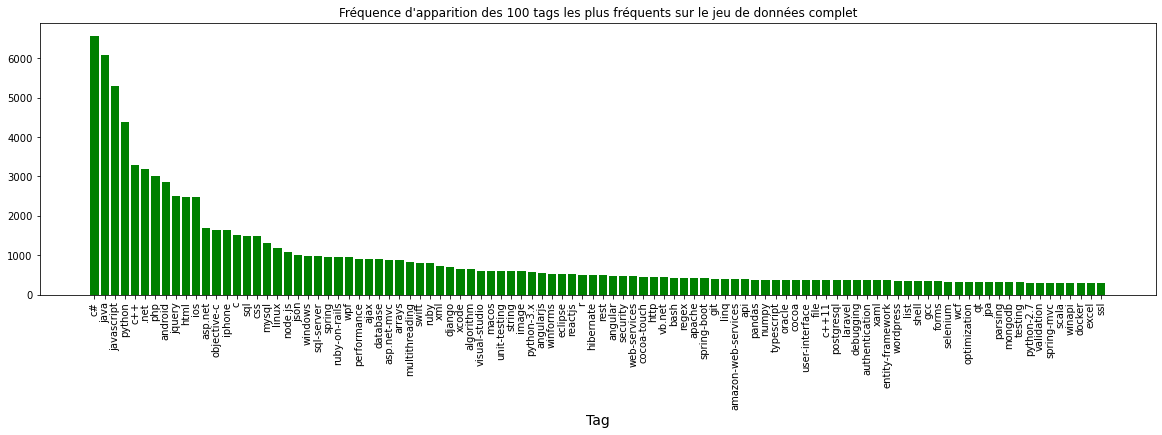

In [37]:
#Préparation d'un graphe d'affichage des 100 tags les plus fréquents
plt.rcParams["figure.figsize"] = [20, 5]
plt.bar('Tags', 'Frequency', data=df_freq_tags[:100], color='g')
plt.xlabel('Tag', fontsize=14)
plt.xticks(rotation=90)
plt.title('Fréquence d\'apparition des 100 tags les plus fréquents sur le jeu de données complet')
plt.show()

In [38]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          50000 non-null  object
 1   Body           50000 non-null  object
 2   Tags           50000 non-null  object
 3   Body_trf       50000 non-null  object
 4   Title_trf      50000 non-null  object
 5   Title_body     50000 non-null  object
 6   Tags_trf_list  50000 non-null  object
 7   Tags_trf_text  50000 non-null  object
dtypes: object(8)
memory usage: 3.1+ MB


In [39]:
raw_data.head(5)

,Title,Body,Tags,Body_trf,Title_trf,Title_body,Tags_trf_list,Tags_trf_text
0,mqtt async wait for concurrent messages then r...,<p>I have this process for home automation pro...,<javascript><node.js><http><async-await><mqtt>,"[process, home, automation, project, receive, ...","[mqtt, async, wait, concurrent, message, respo...","[mqtt, async, wait, concurrent, message, respo...","[javascript, node.js, http, async-await, mqtt]",javascript node.js http async-await mqtt
1,Where can I find a nice .NET Tab Control for f...,<p>I'm doing this application in C# using the ...,<c#><.net><winforms><tabcontrol><krypton>,"[application, using, free, krypton, toolkit, k...","[find, nice, net, tab, control, free]","[find, nice, net, tab, control, free, applicat...","[c#, .net, winforms, tabcontrol, krypton]",c# .net winforms tabcontrol krypton
2,How to smoothly move a button in cocos2d Xcode,"<p>I have a jump button, that when clicked the...",<iphone><ios><cocoa><opengl-es><cocos2d-iphone>,"[jump, button, clicked, player, game, jump, bu...","[smoothly, move, button, coco, xcode]","[smoothly, move, button, coco, xcode, jump, bu...","[iphone, ios, cocoa, opengl-es, cocos2d-iphone]",iphone ios cocoa opengl-es cocos2d-iphone
3,How to get NSImage of generic folder icon on O...,<p>I'm writing a Cocoa application that displa...,<objective-c><cocoa><icons><directory><nsimage>,"[writing, cocoa, application, display, content...","[get, nsimage, generic, folder, icon, o]","[get, nsimage, generic, folder, icon, o, writi...","[objective-c, cocoa, icons, directory, nsimage]",objective-c cocoa icons directory nsimage
4,Replace query string with '/' via .htaccess file,"<p><a href=""http://thewebsitedemo.com/Just-dia...",<php><string><.htaccess><url><replace>,"[http, thewebsitedemo, com, dial, chandigarh, ...","[replace, query, string, via, htaccess, file]","[replace, query, string, via, htaccess, file, ...","[php, string, .htaccess, url, replace]",php string .htaccess url replace


In [40]:
#5 Limitation des tags aux 100 les plus fréquents
# ( Pour notamment les modèles supervisés, il pourra être pertinent de limiter le nombre de tags )

In [41]:
dict_tag = gensim.corpora.Dictionary(raw_data['Tags_trf_list'])

In [42]:
len(dict_tag)

18633

In [43]:
dict_tag.filter_extremes(keep_n=100)

In [44]:
len(dict_tag)

100

In [45]:
print(dict_tag.token2id)

{'http': 0, 'javascript': 1, 'node.js': 2, '.net': 3, 'c#': 4, 'winforms': 5, 'cocoa': 6, 'ios': 7, 'iphone': 8, 'objective-c': 9, 'php': 10, 'string': 11, 'swift': 12, 'c++': 13, 'css': 14, 'html': 15, 'reactjs': 16, 'file': 17, 'asp.net': 18, 'android': 19, 'java': 20, 'xcode': 21, 'linq': 22, 'python': 23, 'sql-server': 24, 'performance': 25, 'windows': 26, 'testing': 27, 'typescript': 28, 'cocoa-touch': 29, 'django': 30, 'mysql': 31, 'api': 32, 'rest': 33, 'angularjs': 34, 'shell': 35, 'ruby': 36, 'sql': 37, 'wpf': 38, 'c++11': 39, 'apache': 40, 'vb.net': 41, 'xaml': 42, 'amazon-web-services': 43, 'c': 44, 'unit-testing': 45, 'authentication': 46, 'database': 47, 'image': 48, 'wcf': 49, 'jquery': 50, 'ajax': 51, 'macos': 52, 'asp.net-mvc': 53, 'visual-studio': 54, 'python-2.7': 55, 'debugging': 56, 'winapi': 57, 'postgresql': 58, 'linux': 59, 'selenium': 60, 'pandas': 61, 'optimization': 62, 'algorithm': 63, 'security': 64, 'ssl': 65, 'arrays': 66, 'ruby-on-rails': 67, 'xml': 68, '

In [46]:
dict_tag[0]

'http'

In [47]:
#  Fonction de conservation des tags appartenant aux 100 tags les plus fréquents

def keep_freq_tags(list):

    words = [x for x in list if x in dict_tag.token2id]

    return words

In [48]:
raw_data['Tags_trf_list_100'] = raw_data['Tags_trf_list'].apply( keep_freq_tags)

In [49]:
raw_data.head(5)

,Title,Body,Tags,Body_trf,Title_trf,Title_body,Tags_trf_list,Tags_trf_text,Tags_trf_list_100
0,mqtt async wait for concurrent messages then r...,<p>I have this process for home automation pro...,<javascript><node.js><http><async-await><mqtt>,"[process, home, automation, project, receive, ...","[mqtt, async, wait, concurrent, message, respo...","[mqtt, async, wait, concurrent, message, respo...","[javascript, node.js, http, async-await, mqtt]",javascript node.js http async-await mqtt,"[javascript, node.js, http]"
1,Where can I find a nice .NET Tab Control for f...,<p>I'm doing this application in C# using the ...,<c#><.net><winforms><tabcontrol><krypton>,"[application, using, free, krypton, toolkit, k...","[find, nice, net, tab, control, free]","[find, nice, net, tab, control, free, applicat...","[c#, .net, winforms, tabcontrol, krypton]",c# .net winforms tabcontrol krypton,"[c#, .net, winforms]"
2,How to smoothly move a button in cocos2d Xcode,"<p>I have a jump button, that when clicked the...",<iphone><ios><cocoa><opengl-es><cocos2d-iphone>,"[jump, button, clicked, player, game, jump, bu...","[smoothly, move, button, coco, xcode]","[smoothly, move, button, coco, xcode, jump, bu...","[iphone, ios, cocoa, opengl-es, cocos2d-iphone]",iphone ios cocoa opengl-es cocos2d-iphone,"[iphone, ios, cocoa]"
3,How to get NSImage of generic folder icon on O...,<p>I'm writing a Cocoa application that displa...,<objective-c><cocoa><icons><directory><nsimage>,"[writing, cocoa, application, display, content...","[get, nsimage, generic, folder, icon, o]","[get, nsimage, generic, folder, icon, o, writi...","[objective-c, cocoa, icons, directory, nsimage]",objective-c cocoa icons directory nsimage,"[objective-c, cocoa]"
4,Replace query string with '/' via .htaccess file,"<p><a href=""http://thewebsitedemo.com/Just-dia...",<php><string><.htaccess><url><replace>,"[http, thewebsitedemo, com, dial, chandigarh, ...","[replace, query, string, via, htaccess, file]","[replace, query, string, via, htaccess, file, ...","[php, string, .htaccess, url, replace]",php string .htaccess url replace,"[php, string]"


In [50]:
# Création d'une donnée Tags en zone de texte limitée aux 100 tags les plus fréquents
for k in range (len(raw_data)):
    raw_data.loc[raw_data.index[k],'Tags_trf_text_100'] = ' '.join(raw_data.iloc[k]['Tags_trf_list_100'])

In [51]:
# Création d'une donnée Title-Body en zone de texte et non en liste (utile pour notamment les modèles de word embedding)
for k in range (len(raw_data)):
    raw_data.loc[raw_data.index[k],'Title_body_text'] = ' '.join(raw_data.iloc[k]['Title_body'])

In [52]:
raw_data.head(5)

,Title,Body,Tags,Body_trf,Title_trf,Title_body,Tags_trf_list,Tags_trf_text,Tags_trf_list_100,Tags_trf_text_100,Title_body_text
0,mqtt async wait for concurrent messages then r...,<p>I have this process for home automation pro...,<javascript><node.js><http><async-await><mqtt>,"[process, home, automation, project, receive, ...","[mqtt, async, wait, concurrent, message, respo...","[mqtt, async, wait, concurrent, message, respo...","[javascript, node.js, http, async-await, mqtt]",javascript node.js http async-await mqtt,"[javascript, node.js, http]",javascript node.js http,mqtt async wait concurrent message respond res...
1,Where can I find a nice .NET Tab Control for f...,<p>I'm doing this application in C# using the ...,<c#><.net><winforms><tabcontrol><krypton>,"[application, using, free, krypton, toolkit, k...","[find, nice, net, tab, control, free]","[find, nice, net, tab, control, free, applicat...","[c#, .net, winforms, tabcontrol, krypton]",c# .net winforms tabcontrol krypton,"[c#, .net, winforms]",c# .net winforms,find nice net tab control free application usi...
2,How to smoothly move a button in cocos2d Xcode,"<p>I have a jump button, that when clicked the...",<iphone><ios><cocoa><opengl-es><cocos2d-iphone>,"[jump, button, clicked, player, game, jump, bu...","[smoothly, move, button, coco, xcode]","[smoothly, move, button, coco, xcode, jump, bu...","[iphone, ios, cocoa, opengl-es, cocos2d-iphone]",iphone ios cocoa opengl-es cocos2d-iphone,"[iphone, ios, cocoa]",iphone ios cocoa,smoothly move button coco xcode jump button cl...
3,How to get NSImage of generic folder icon on O...,<p>I'm writing a Cocoa application that displa...,<objective-c><cocoa><icons><directory><nsimage>,"[writing, cocoa, application, display, content...","[get, nsimage, generic, folder, icon, o]","[get, nsimage, generic, folder, icon, o, writi...","[objective-c, cocoa, icons, directory, nsimage]",objective-c cocoa icons directory nsimage,"[objective-c, cocoa]",objective-c cocoa,get nsimage generic folder icon o writing coco...
4,Replace query string with '/' via .htaccess file,"<p><a href=""http://thewebsitedemo.com/Just-dia...",<php><string><.htaccess><url><replace>,"[http, thewebsitedemo, com, dial, chandigarh, ...","[replace, query, string, via, htaccess, file]","[replace, query, string, via, htaccess, file, ...","[php, string, .htaccess, url, replace]",php string .htaccess url replace,"[php, string]",php string,replace query string via htaccess file http th...


In [53]:
#6 Séparation du jeu de données en train / test

In [54]:
raw_data_train, raw_data_test = train_test_split(raw_data, test_size=0.3,random_state=42)

In [55]:
raw_data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35000 entries, 38094 to 15795
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Title              35000 non-null  object
 1   Body               35000 non-null  object
 2   Tags               35000 non-null  object
 3   Body_trf           35000 non-null  object
 4   Title_trf          35000 non-null  object
 5   Title_body         35000 non-null  object
 6   Tags_trf_list      35000 non-null  object
 7   Tags_trf_text      35000 non-null  object
 8   Tags_trf_list_100  35000 non-null  object
 9   Tags_trf_text_100  35000 non-null  object
 10  Title_body_text    35000 non-null  object
dtypes: object(11)
memory usage: 3.2+ MB


In [56]:
# Calcul de fréquence des différents tags sur les données de train
freq_tags = raw_data_train['Tags_trf_text_100'].str.cat(sep=' ')
words = freq_tags.split()
Word_dist = nltk.FreqDist(words)
df_freq_tags = pd.DataFrame(Word_dist.most_common(),columns=['Tags', 'Frequency'])
df_freq_tags

,Tags,Frequency
0,c#,4626
1,java,4239
2,javascript,3764
3,python,2993
4,c++,2316
...,...,...
95,wcf,209
96,mongodb,206
97,python-2.7,204
98,ssl,203


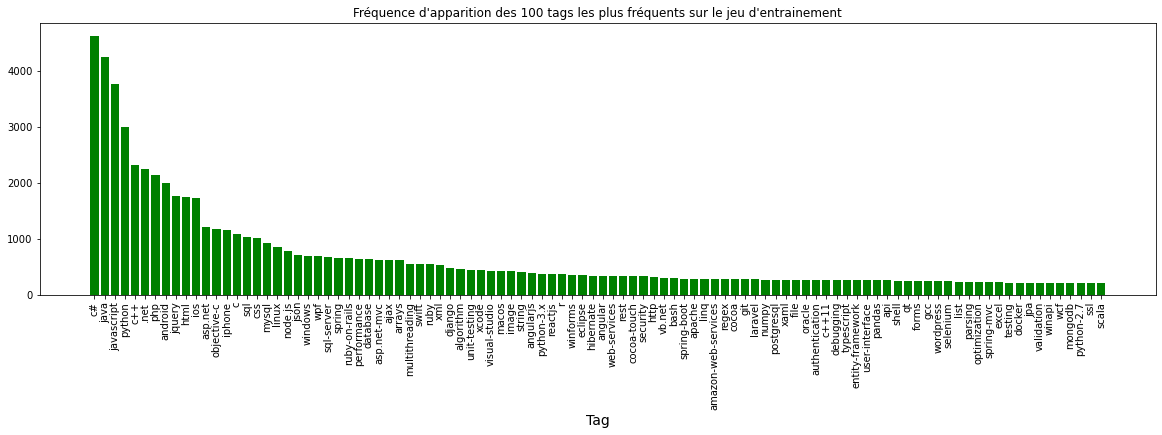

In [57]:
#Préparation d'un graphe d'affichage des 100 tags les plus fréquents sur le jeu d'entraînement
plt.rcParams["figure.figsize"] = [20, 5]
plt.bar('Tags', 'Frequency', data=df_freq_tags[:100], color='g')
plt.xlabel('Tag', fontsize=14)
plt.xticks(rotation=90)
plt.title('Fréquence d\'apparition des 100 tags les plus fréquents sur le jeu d\'entrainement')
plt.show()

In [58]:
# Calcul de fréquence des différents tags sur les données de test
freq_tags = raw_data_test['Tags_trf_text_100'].str.cat(sep=' ')
words = freq_tags.split()
Word_dist = nltk.FreqDist(words)
df_freq_tags = pd.DataFrame(Word_dist.most_common(),columns=['Tags', 'Frequency'])
df_freq_tags

,Tags,Frequency
0,c#,1949
1,java,1857
2,javascript,1541
3,python,1390
4,c++,972
...,...,...
95,winapi,91
96,docker,86
97,spring-mvc,84
98,qt,81


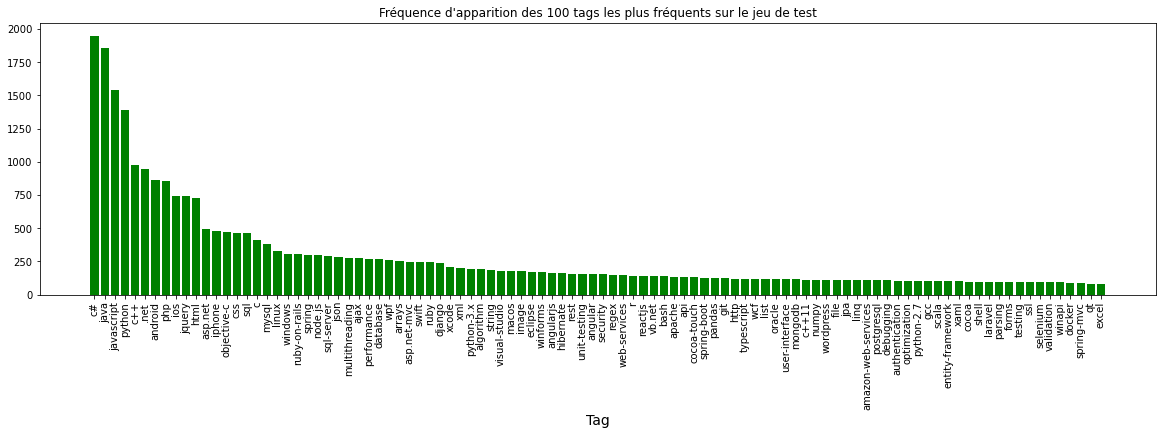

In [59]:
#Préparation d'un graphe d'affichage des 100 tags les plus fréquents sur le jeu de test
plt.rcParams["figure.figsize"] = [20, 5]
plt.bar('Tags', 'Frequency', data=df_freq_tags[:100], color='g')
plt.xlabel('Tag', fontsize=14)
plt.xticks(rotation=90)
plt.title('Fréquence d\'apparition des 100 tags les plus fréquents sur le jeu de test')
plt.show()

In [60]:
df_freq_tags= df_freq_tags.set_index('Tags')

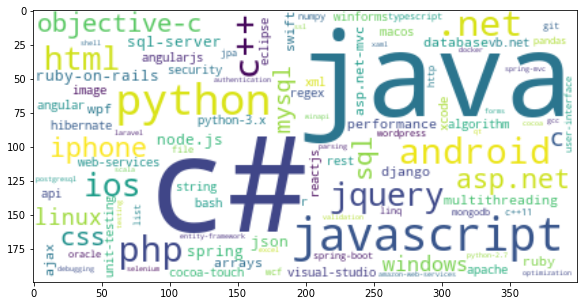

In [61]:
# Affichage du nuage de tags réels sur le jeu de tests
cloud_generator = WordCloud(background_color = 'white', random_state=1)
wordcloud_image = cloud_generator.fit_words(df_freq_tags['Frequency'])
plt.imshow(wordcloud_image, interpolation = "bilinear")

In [62]:
#7 Bag of words : dans un premier temps en utilisant l'équivalent de CountVectorizer côté gensim

In [63]:
# Plusieurs approches :
#      Approche 1 : bow_cv_ft_tt : fit et transform sur title
#      Approche 2 : bow_cv_ftb_ttb : fit et transform sur title + body
#      Approche 3 : bow_cv_ft_ttb : fit sur title et transform sur title + body

# Pour chaque approche seront conservés:
#       bow_cv_xx_xx_train  : le bag of word issu de countvectorizer sur les données de train
#       bow_cv_xx_xx_test  : le bag of word issu de countvectorizer appliqué sur les données de test
#       bow_cv_xx_xx_words  : le dictionnaire du bag of words issu de countvectorizer

In [64]:
# Illustration de ce bag of words si on l'appliquait aux 3 premières lignes des données d'entraînement
example = raw_data_train.head(3).copy()
example

,Title,Body,Tags,Body_trf,Title_trf,Title_body,Tags_trf_list,Tags_trf_text,Tags_trf_list_100,Tags_trf_text_100,Title_body_text
38094,Problem converting a Matrix to Data Frame in R...,<p>I am passing data from C# to R over a COM i...,<data-structures><r><matrix><type-conversion><...,"[passing, data, com, interface, data, arrives,...","[problem, converting, matrix, data, frame, thi...","[problem, converting, matrix, data, frame, thi...","[data-structures, r, matrix, type-conversion, ...",data-structures r matrix type-conversion dataf...,[r],r,problem converting matrix data frame think num...
40624,Launch a batch file stored in different direct...,<p>I have created a Python script which needs ...,<python><batch-file><subprocess><call><popen>,"[created, python, script, need, launch, bat, f...","[launch, batch, file, stored, different, direc...","[launch, batch, file, stored, different, direc...","[python, batch-file, subprocess, call, popen]",python batch-file subprocess call popen,[python],python,launch batch file stored different directory p...
49425,Is making a function template specialization v...,"<p>In C++, a function template specialization ...",<c++><templates><virtual><specialization><c1001>,"[function, template, specialization, supposed,...","[making, function, template, specialization, v...","[making, function, template, specialization, v...","[c++, templates, virtual, specialization, c1001]",c++ templates virtual specialization c1001,[c++],c++,making function template specialization virtua...


In [65]:
id2word = corpora.Dictionary(example['Title_trf'])
texts = example['Title_trf']
corpus = [id2word.doc2bow(text) for text in texts]

In [66]:
print(corpus)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)], [(9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)], [(18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1)]]


In [67]:
all_topics_csr = gensim.matutils.corpus2csc(corpus)
all_topics_numpy = all_topics_csr.T.toarray()
example_df=pd.DataFrame(all_topics_numpy,columns=list(id2word))
for k in range(len(id2word)):
    example_df = example_df.rename(columns={k: id2word[k]})
example_df

,converting,data,factor,frame,matrix,numeric,problem,think,type,another,...,launch,python,script,stored,function,legal,making,specialization,template,virtual
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0


In [68]:
#      Approche 1 : bow_cv_ft_tt : fit et transform sur title
id2word = corpora.Dictionary(raw_data_train['Title_trf'])
texts = raw_data_train['Title_trf']
bow_cv_ft_tt_train = [id2word.doc2bow(text) for text in texts]
texts = raw_data_test['Title_trf']
bow_cv_ft_tt_test = [id2word.doc2bow(text) for text in texts]
bow_cv_ft_tt_words = id2word

In [69]:
len(bow_cv_ft_tt_words)

17542

In [70]:
print(bow_cv_ft_tt_words)

Dictionary(17542 unique tokens: ['converting', 'data', 'factor', 'frame', 'matrix']...)


In [71]:
len(bow_cv_ft_tt_train)

35000

In [72]:
bow_cv_ft_tt_train[0]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]

In [73]:
#      Approche 2 : bow_cv_ftb_ttb : fit et transform sur title + body
id2word = corpora.Dictionary(raw_data_train['Title_body'])
texts = raw_data_train['Title_body']
bow_cv_ftb_ttb_train = [id2word.doc2bow(text) for text in texts]
texts = raw_data_test['Title_body']
bow_cv_ftb_ttb_test = [id2word.doc2bow(text) for text in texts]
bow_cv_ftb_ttb_words = id2word

In [74]:
len(bow_cv_ftb_ttb_words)

203368

In [75]:
#      Approche 3 : bow_cv_ft_ttb : fit sur title et transform sur title + body
id2word = corpora.Dictionary(raw_data_train['Title_trf'])
texts = raw_data_train['Title_body']
bow_cv_ft_ttb_train = [id2word.doc2bow(text) for text in texts]
texts = raw_data_test['Title_body']
bow_cv_ft_ttb_test = [id2word.doc2bow(text) for text in texts]
bow_cv_ft_ttb_words = id2word

In [76]:
len(bow_cv_ft_ttb_words)

17542

In [77]:
#8 Bag of words : en utilisant tfidfmodel

In [78]:
# Plusieurs approches :
#      Approche 1 : bow_tv_ft_tt : fit et transform sur title
#      Approche 2 : bow_tv_ftb_ttb : fit et transform sur title + body
#      Approche 3 : bow_tv_ft_ttb : fit sur title et transform sur title + body

# Pour chaque approche seront conservés:
#       bow_tv_xx_xx_train  : le bag of word issu de tfidfVectorizer sur les données de train
#       bow_tv_xx_xx_test  : le bag of word issu de tfidfVectorizer appliqué sur les données de test
#       bow_tv_xx_xx_words  : le dictionnaire du bag of words issu de tfidfVectorizer

In [79]:
# Illustration de ce bag of words si on l'appliquait aux 3 premières lignes des données d'entraînement
example = raw_data_train.head(3).copy()
example

,Title,Body,Tags,Body_trf,Title_trf,Title_body,Tags_trf_list,Tags_trf_text,Tags_trf_list_100,Tags_trf_text_100,Title_body_text
38094,Problem converting a Matrix to Data Frame in R...,<p>I am passing data from C# to R over a COM i...,<data-structures><r><matrix><type-conversion><...,"[passing, data, com, interface, data, arrives,...","[problem, converting, matrix, data, frame, thi...","[problem, converting, matrix, data, frame, thi...","[data-structures, r, matrix, type-conversion, ...",data-structures r matrix type-conversion dataf...,[r],r,problem converting matrix data frame think num...
40624,Launch a batch file stored in different direct...,<p>I have created a Python script which needs ...,<python><batch-file><subprocess><call><popen>,"[created, python, script, need, launch, bat, f...","[launch, batch, file, stored, different, direc...","[launch, batch, file, stored, different, direc...","[python, batch-file, subprocess, call, popen]",python batch-file subprocess call popen,[python],python,launch batch file stored different directory p...
49425,Is making a function template specialization v...,"<p>In C++, a function template specialization ...",<c++><templates><virtual><specialization><c1001>,"[function, template, specialization, supposed,...","[making, function, template, specialization, v...","[making, function, template, specialization, v...","[c++, templates, virtual, specialization, c1001]",c++ templates virtual specialization c1001,[c++],c++,making function template specialization virtua...


In [80]:
id2word = corpora.Dictionary(example['Title_trf'])
texts = example['Title_trf']
bow_corpus = [id2word.doc2bow(text) for text in texts]
tfidf = TfidfModel(bow_corpus)
tfidf_corpus = [tfidf[text] for text in bow_corpus]

In [81]:
print(tfidf_corpus)

[[(0, 0.3333333333333333), (1, 0.3333333333333333), (2, 0.3333333333333333), (3, 0.3333333333333333), (4, 0.3333333333333333), (5, 0.3333333333333333), (6, 0.3333333333333333), (7, 0.3333333333333333), (8, 0.3333333333333333)], [(9, 0.2886751345948129), (10, 0.2886751345948129), (11, 0.2886751345948129), (12, 0.5773502691896258), (13, 0.2886751345948129), (14, 0.2886751345948129), (15, 0.2886751345948129), (16, 0.2886751345948129), (17, 0.2886751345948129)], [(18, 0.408248290463863), (19, 0.408248290463863), (20, 0.408248290463863), (21, 0.408248290463863), (22, 0.408248290463863), (23, 0.408248290463863)]]


In [82]:
all_topics_csr = gensim.matutils.corpus2csc(tfidf_corpus)
all_topics_numpy = all_topics_csr.T.toarray()
example_df=pd.DataFrame(all_topics_numpy,columns=list(id2word))
for k in range(len(id2word)):
    example_df = example_df.rename(columns={k: id2word[k]})
example_df

,converting,data,factor,frame,matrix,numeric,problem,think,type,another,...,launch,python,script,stored,function,legal,making,specialization,template,virtual
0,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.288675,...,0.288675,0.288675,0.288675,0.288675,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.408248,0.408248,0.408248,0.408248,0.408248,0.408248


In [83]:
#      Approche 1 : bow_tv_ft_tt : fit et transform sur title
id2word = corpora.Dictionary(raw_data_train['Title_trf'])
texts = raw_data_train['Title_trf']
bow_corpus = [id2word.doc2bow(text) for text in texts]
tfidf = TfidfModel(bow_corpus)
bow_tv_ft_tt_train = [tfidf[text] for text in bow_corpus]
texts = raw_data_test['Title_trf']
bow_corpus = [id2word.doc2bow(text) for text in texts]
tfidf = TfidfModel(bow_corpus)
bow_tv_ft_tt_test = [tfidf[text] for text in bow_corpus]
bow_tv_ft_tt_words=id2word

In [84]:
len(bow_tv_ft_tt_words)

17542

In [85]:
print(bow_tv_ft_tt_words)

Dictionary(17542 unique tokens: ['converting', 'data', 'factor', 'frame', 'matrix']...)


In [86]:
bow_tv_ft_tt_train[0]

[(0, 0.30823715713985295),
 (1, 0.18038193304461622),
 (2, 0.4532868056057119),
 (3, 0.31726941705416223),
 (4, 0.31256489651485947),
 (5, 0.3875188912802271),
 (6, 0.2529986418524631),
 (7, 0.4532868056057119),
 (8, 0.22131076681329362)]

In [87]:
#      Approche 2 : bow_tv_ftb_ttb : fit et transform sur title + body
id2word = corpora.Dictionary(raw_data_train['Title_body'])
texts = raw_data_train['Title_body']
bow_corpus = [id2word.doc2bow(text) for text in texts]
tfidf = TfidfModel(bow_corpus)
bow_tv_ftb_ttb_train = [tfidf[text] for text in bow_corpus]
texts = raw_data_test['Title_body']
bow_corpus = [id2word.doc2bow(text) for text in texts]
tfidf = TfidfModel(bow_corpus)
bow_tv_ftb_ttb_test = [tfidf[text] for text in bow_corpus]
bow_tv_ftb_ttb_words=id2word

In [88]:
len(bow_tv_ftb_ttb_words)

203368

In [89]:
bow_tv_ftb_ttb_train[0]

[(0, 0.056046504469395984),
 (1, 0.17270736662761924),
 (2, 0.12793290933506962),
 (3, 0.11873011873020717),
 (4, 0.05338679581546431),
 (5, 0.034858668590012985),
 (6, 0.08670052643556447),
 (7, 0.05866707080701504),
 (8, 0.08385755741252335),
 (9, 0.08375840237455422),
 (10, 0.3336073648911103),
 (11, 0.1929688452569432),
 (12, 0.34633958905134016),
 (13, 0.1368193492566614),
 (14, 0.05050847752921752),
 (15, 0.0694113497059881),
 (16, 0.29220685723370954),
 (17, 0.10562011938139215),
 (18, 0.04476392156382098),
 (19, 0.07846510683208244),
 (20, 0.20499212905391961),
 (21, 0.10898263804675708),
 (22, 0.06225211144212107),
 (23, 0.07770184787211742),
 (24, 0.14714022719043376),
 (25, 0.1308665065141314),
 (26, 0.1929688452569432),
 (27, 0.1801852755383505),
 (28, 0.0373298339760106),
 (29, 0.05286089644243987),
 (30, 0.04834981727978629),
 (31, 0.06003578028527495),
 (32, 0.03298612563761158),
 (33, 0.0683521423339292),
 (34, 0.16811496248334373),
 (35, 0.1929688452569432),
 (36, 0.14

In [90]:
#      Approche 3 : bow_tv_ft_ttb : fit sur title et transform sur title + body
id2word = corpora.Dictionary(raw_data_train['Title_trf'])
texts = raw_data_train['Title_body']
bow_corpus = [id2word.doc2bow(text) for text in texts]
tfidf = TfidfModel(bow_corpus)
bow_tv_ft_ttb_train = [tfidf[text] for text in bow_corpus]
texts = raw_data_test['Title_body']
bow_corpus = [id2word.doc2bow(text) for text in texts]
tfidf = TfidfModel(bow_corpus)
bow_tv_ft_ttb_test = [tfidf[text] for text in bow_corpus]
bow_tv_ft_ttb_words=id2word

In [91]:
len(bow_tv_ft_ttb_words)

17542

In [92]:
bow_tv_ft_ttb_train[0]

[(0, 0.10088456048575133),
 (1, 0.40134525044993913),
 (2, 0.35153850496655453),
 (3, 0.24661511115698972),
 (4, 0.20225015639053012),
 (5, 0.3629305820421731),
 (6, 0.03443756807226582),
 (7, 0.05858972233657072),
 (8, 0.03897492323943755),
 (18, 0.07489219929521217),
 (43, 0.05274208373653256),
 (58, 0.077612530125637),
 (62, 0.0835050974996039),
 (106, 0.09439719043187861),
 (120, 0.11132514901882075),
 (271, 0.06359412877058056),
 (337, 0.024805002857139654),
 (378, 0.4166627111302215),
 (414, 0.053244009356222456),
 (415, 0.02942498979171371),
 (418, 0.0722258493376363),
 (442, 0.07057922787133646),
 (465, 0.03968385068393661),
 (495, 0.10430478508105151),
 (497, 0.05816708972147068),
 (507, 0.04193660736529798),
 (622, 0.07822859526690477),
 (708, 0.09347895423363009),
 (774, 0.1311112066601031),
 (904, 0.09182856236162736),
 (956, 0.0738095220016622),
 (960, 0.06422681029320476),
 (1125, 0.1007652723412582),
 (1263, 0.08397454650465679),
 (1307, 0.06747958095078085),
 (1781, 0.0

In [93]:
#9 Sauvegarde des différentes objets pour utilisation dans le notebook de modélisation
# Objets à conserver :
#     raw_data_train, raw_data_test
#     bow_cv_ft_tt_train, bow_cv_ft_tt_test, bow_cv_ft_tt_words
#     bow_cv_ftb_ttb_train, bow_cv_ftb_ttb_test, bow_cv_ftb_ttb_words
#     bow_cv_ft_ttb_train, bow_cv_ft_ttb_test, bow_cv_ft_ttb_words
#     bow_tv_ft_tt_train, bow_tv_ft_tt_test, bow_tv_ft_tt_words
#     bow_tv_ftb_ttb_train, bow_tv_ftb_ttb_test, bow_tv_ftb_ttb_words
#     bow_tv_ft_ttb_train, bow_tv_ft_ttb_test, bow_tv_ft_ttb_words
#     Dictionnaire de tags dict_tag

In [94]:
raw_data_train.to_pickle('export_raw_data_train.pkl')
raw_data_test.to_pickle('export_raw_data_test.pkl')
file = open('export_bow_cv_ft_tt_train.pkl', 'wb')
pickle.dump(bow_cv_ft_tt_train, file)
file.close()
file = open('export_bow_cv_ft_tt_test.pkl', 'wb')
pickle.dump(bow_cv_ft_tt_test, file)
file.close()
file = open('export_bow_cv_ft_tt_words.pkl', 'wb')
pickle.dump(bow_cv_ft_tt_words, file)
file.close()
file = open('export_bow_cv_ftb_ttb_train.pkl', 'wb')
pickle.dump(bow_cv_ftb_ttb_train, file)
file.close()
file = open('export_bow_cv_ftb_ttb_test.pkl', 'wb')
pickle.dump(bow_cv_ftb_ttb_test, file)
file.close()
file = open('export_bow_cv_ftb_ttb_words.pkl', 'wb')
pickle.dump(bow_cv_ftb_ttb_words, file)
file.close()
file = open('export_bow_cv_ft_ttb_train.pkl', 'wb')
pickle.dump(bow_cv_ft_ttb_train, file)
file.close()
file = open('export_bow_cv_ft_ttb_test.pkl', 'wb')
pickle.dump(bow_cv_ft_ttb_test, file)
file.close()
file = open('export_bow_cv_ft_ttb_words.pkl', 'wb')
pickle.dump(bow_cv_ft_ttb_words, file)
file.close()
file = open('export_bow_tv_ft_tt_train.pkl', 'wb')
pickle.dump(bow_tv_ft_tt_train, file)
file.close()
file = open('export_bow_tv_ft_tt_test.pkl', 'wb')
pickle.dump(bow_tv_ft_tt_test, file)
file.close()
file = open('export_bow_tv_ft_tt_words.pkl', 'wb')
pickle.dump(bow_tv_ft_tt_words, file)
file.close()
file = open('export_bow_tv_ftb_ttb_train.pkl', 'wb')
pickle.dump(bow_tv_ftb_ttb_train, file)
file.close()
file = open('export_bow_tv_ftb_ttb_test.pkl', 'wb')
pickle.dump(bow_tv_ftb_ttb_test, file)
file.close()
file = open('export_bow_tv_ftb_ttb_words.pkl', 'wb')
pickle.dump(bow_tv_ftb_ttb_words, file)
file.close()
file = open('export_bow_tv_ft_ttb_train.pkl', 'wb')
pickle.dump(bow_tv_ft_ttb_train, file)
file.close()
file = open('export_bow_tv_ft_ttb_test.pkl', 'wb')
pickle.dump(bow_tv_ft_ttb_test, file)
file.close()
file = open('export_bow_tv_ft_ttb_words.pkl', 'wb')
pickle.dump(bow_tv_ft_ttb_words, file)
file.close()
file = open('export_dict_tag.pkl', 'wb')
pickle.dump(dict_tag, file)
file.close()